## Install Packages

In [15]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu117
0.15.2+cu117


## Import 

# Setup

In [1]:
# Ensure autoreload is enabled
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
from time import sleep
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchinfo import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torchmetrics import ConfusionMatrix
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import time
import copy
from utilities.helper import save_model, get_num_correct, create_target_dir, create_dir

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import numpy as np
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Use a fixed seed value

In [4]:
## Unzip the data 

In [5]:
CURRENT_DIR = os.getcwd()
#DATA_DIR = 'Datasets/Clothes'
#PATH_TO_DATA =  os.path.join(CURRENT_DIR,DATA_DIR)
#print(PATH_TO_DATA)

In [6]:
DATA_DIR = Path('Datasets/Clothes')

DATA_DIR

PosixPath('Datasets/Clothes')

# Visualize an image

In [7]:
import random
from PIL import Image

# set seed
#random.seed(42)
# Get all image paths 
image_path_list = list(DATA_DIR.glob('*/*.jpg'))
 
# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name 
image_class = random_image_path.parent.stem

# Open Image
img = Image.open(random_image_path)

Random image path: Datasets/Clothes/Lyon's/36.jpg
Image class: Lyon's
Image height: 256
Image width: 256
Image color_channels: 3


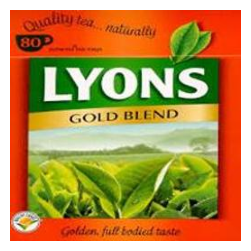

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
print(f"Image color_channels: {img_as_array.shape[2]}")
# Turn the image into an array

# Plot the image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.axis(False);

In [9]:
import torch
print("Number of CUDA devices available:", torch.cuda.device_count())

num_workers = os.cpu_count()
print(num_workers)

Number of CUDA devices available: 1
24


In [10]:
class PadTensor(object):
    def __init__(self, padding):
        # Padding can be a single integer or a tuple (left, right, top, bottom)
        self.padding = padding  

    def __call__(self, tensor):
        # Pad the tensor and specify the padding mode
        # 'constant' mode adds constant valued padding, and 0 is the padding value
        return torch.nn.functional.pad(tensor, self.padding, mode='constant', value=0)

## Data augmentaion and normalizaion

In [11]:
# Create transform function
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5), # data augmentation
    #transforms.RandomRotation(45),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #transforms.Lambda(lambda image: image.convert('RGB')),
    #transforms.RandomRotation(85),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.GaussianBlur(kernel_size = (7,13), sigma = (6 , 7)),
    #transforms.ColorJitter(brightness=(0.5,1.5),contrast=(2),saturation=(1.4),hue=(-0.1,0.5)),
    transforms.ToTensor(),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std) # normalization
])
transforms_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.CenterCrop((224, 224)),
    #transforms.RandomRotation(45),
    transforms.ToTensor(),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std)
])

data_transforms = {
    'train': transforms_train,
    'valid': transforms_valid,
}

In [12]:
transforms_train(img).shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


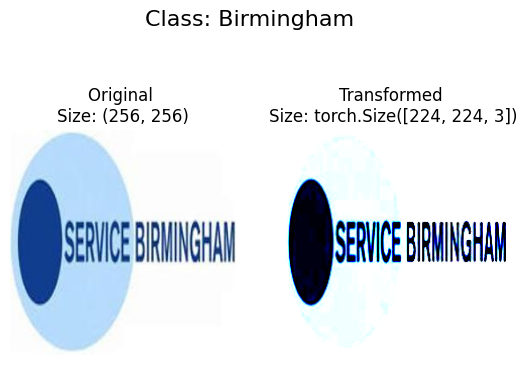

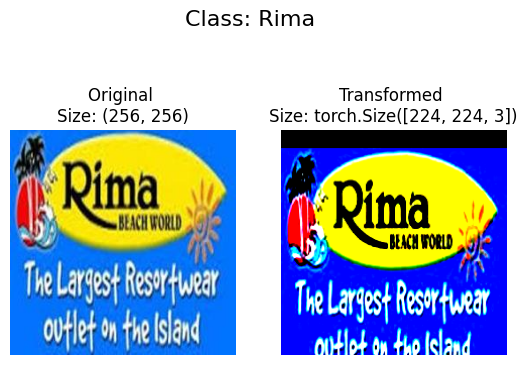

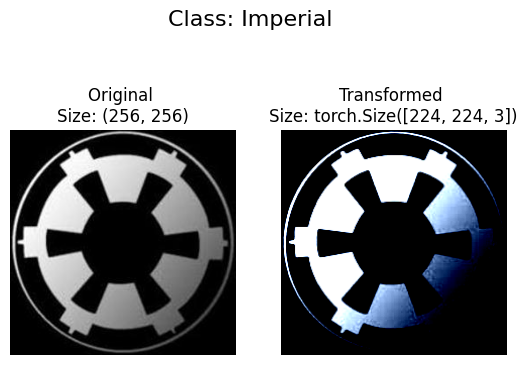

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=transforms_train, 
                        n=3)

In [14]:
from typing import Tuple, Dict, List
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

## Load Data

## Set up path for data after downloading

In [15]:
from torch.utils.data import random_split
from sklearn.model_selection import KFold
# Load the dataset

# Ensure all files are valid images
def is_valid_file(path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
    return os.path.splitext(path)[1].lower() in valid_extensions

# Load the dataset with valid file checker
try:
    dataset = datasets.ImageFolder(DATA_DIR, is_valid_file=is_valid_file, transform=None)
    print("Dataset loaded successfully.")
    
    random.seed(42)
    # Split the dataset into train and test sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, test_size])

    # Apply different transforms to train and test datasets using a custom Dataset
    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, transform=None):
            self.dataset = dataset
            self.transform = transform

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            image, label = self.dataset[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

    # Create datasets with appropriate transformations
    train_dataset = CustomDataset(train_dataset, transform=transforms_train)
    valid_dataset = CustomDataset(valid_dataset, transform=transforms_valid)
except Exception as e:
    print(f"Error loading dataset: {e}")
#dataset = datasets.ImageFolder(DATA_DIR, transform=None)

Dataset loaded successfully.


In [16]:
print(len(train_dataset))
print(len(valid_dataset))

16450
4113


In [17]:
img, label = train_dataset[0]

In [18]:
train_dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
    Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
)

In [19]:
batch_size = 24


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                               num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Valid dataset size:', len(valid_dataset))
class_names = dataset.classes
#print('Class names:', class_names)

num_classes = len(class_names)
print('Class numbers:', num_classes)
print()
print('Train dataloader size (number of batches):', len(train_dataloader))
print('Valid dataloader size (number of batches):', len(valid_dataloader))
print('Train dataset size:', len(train_dataloader.dataset))
print('Valid dataset size::', len(valid_dataloader.dataset))

Train dataset size: 16450
Valid dataset size: 4113
Class numbers: 287

Train dataloader size (number of batches): 686
Valid dataloader size (number of batches): 172
Train dataset size: 16450
Valid dataset size:: 4113


#  Visualize data after transformation

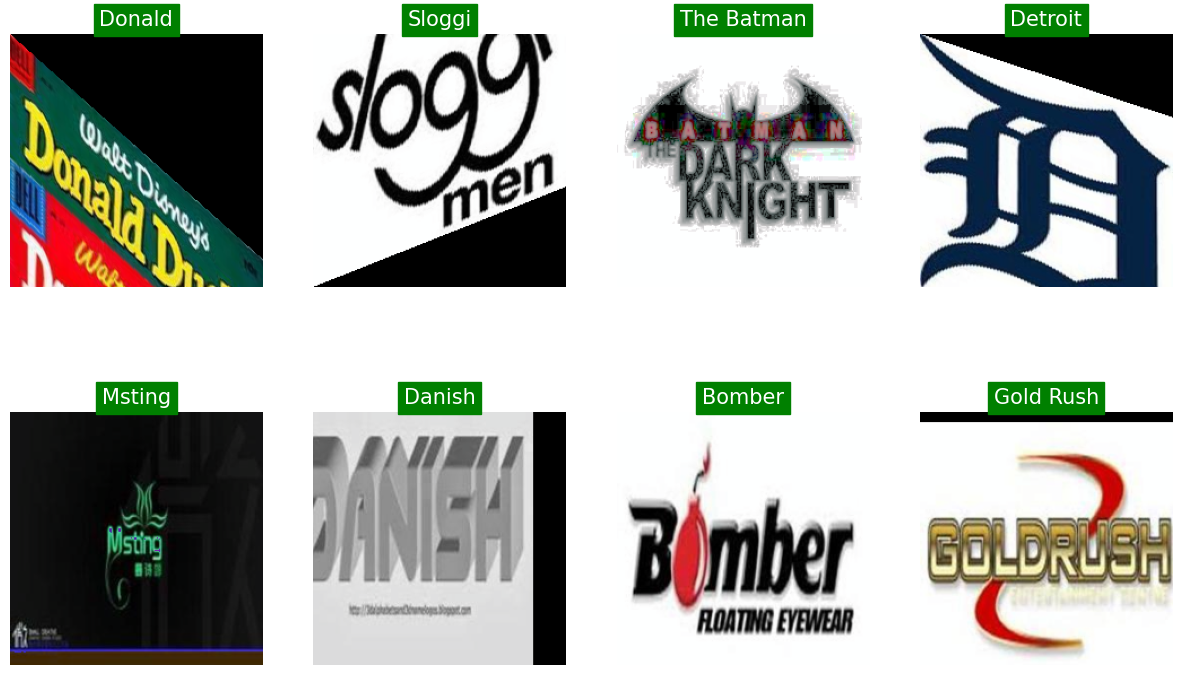

In [20]:
fig = plt.figure(figsize=(15,9))
rows, cols = 2, 4

# Load a batch of train images
iterator = iter(train_dataloader)
inputs, classes = next(iterator)
def imshow(input, title, ax):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    ax.imshow(input)
    ax.set_title(title, fontsize=15, color='white', backgroundcolor='green')
    ax.axis('off')  # Hide axes

# Loop through the first 8 images in the batch
for i in range(1, 9):
    ax = fig.add_subplot(rows, cols, i)
    # Display each image in its subplot
    imshow(inputs[i - 1], class_names[classes[i - 1]], ax)

plt.show()

## Load pre-trained ResNet-18 model 

In [21]:
class Resnet50(nn.Module):
    def __init__(self, num_classes, pretrained, fine_tune):
        super(Resnet50, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
                # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the last layer
        
        # Assuming the features output from Resnet50 is of size 2048
        self.classifier_layer = nn.Sequential(
            #nn.Dropout(p=0.3, inplace=False),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            #nn.ReLU(),
            #nn.Dropout(p=0.3, inplace=False),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            #nn.ReLU(),
            #nn.Dropout(p=0.2, inplace=False),
            nn.Linear(512, num_classes),
            nn.BatchNorm1d(num_classes),
            nn.Dropout(p=0.3, inplace=True)
            #nn.Linear(128, num_classes)
            # nn.LogSoftmax(dim=1)
        )
        model_name = self.__class__.__name__
        print(f"Model: {model_name}")
        print(f'[INFO]: Number of infeatures:{num_features}')
        if fine_tune:
            print('[INFO]: Fine-tuning all layers...')
            for params in model.parameters():
                params.requires_grad = True
        elif not fine_tune:
            print('[INFO]: Freezing hidden layers...')
            self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier_layer(x)
        return x
    
    def freeze_layers(self):
        # Freeze layers except for 'layer3', 'layer4', and 'classifier_layer'
        for name, child in self.model.named_children():
            if name in ['layer3', 'layer4']:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False 
            
        for params in self.classifier_layer.parameters():
            params.requires_grad = True

In [22]:
class Resnet18(nn.Module):
    def __init__(self, num_classes, pretrained, fine_tune):
        super(Resnet18, self).__init__()
        self.model = models.resnet18(pretrained=pretrained)
                # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the last layer
        # Assuming the features output from Resnet50 is of size 2048
        self.classifier_layer = nn.Sequential(
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(num_features, num_classes),
            nn.BatchNorm1d(num_classes),
            #nn.Linear(128, num_classes)
            # nn.LogSoftmax(dim=1)
            #nn.ReLU(),  # Optional: Add if you want to add non-linearity
            #nn.Softmax(dim=1)  # Optional: Add if you need probabilities
        )
        
    
        model_name = self.__class__.__name__
        print(f"Model: {model_name}")
        print(f'[INFO]: Number of infeatures:{num_features}')
        if fine_tune:
            print('[INFO]: Fine-tuning all layers...')
            for params in self.model.parameters():
                params.requires_grad = True
        elif not fine_tune:
            print('[INFO]: Freezing hidden layers...')
            self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier_layer(x)
        return x
    
    def freeze_layers(self):
        # Freeze layers except for 'layer3', 'layer4', and 'classifier_layer'
        for name, child in self.model.named_children():
            if name in ['layer3', 'layer4']:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False 
            
        for params in self.classifier_layer.parameters():
            params.requires_grad = True  

In [23]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

In [24]:
#model = Resnet18(num_classes=num_classes, pretrained=True, fine_tune=False)
model = Resnet50(num_classes=num_classes, pretrained=True, fine_tune=False)

Model: Resnet50
[INFO]: Number of infeatures:2048
[INFO]: Freezing hidden layers...


In [25]:
model.classifier_layer = nn.Identity()

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [27]:
model = model.eval()

In [29]:
def extract_features(loader, model, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_dataloader, model,device )
test_features, test_labels = extract_features(valid_dataloader, model,device)


In [30]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}


In [37]:
import multiprocessing
n_jobs = multiprocessing.cpu_count()-1

In [38]:
n_jobs

23

In [39]:
svc = SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(train_features, train_labels)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")


Fitting 5 folds for each of 64 candidates, totalling 320 fits


KeyboardInterrupt: 

In [ ]:
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy}")

In [25]:
# Custom learning rate scheduler
import math
class CustomLRScheduler:
    def __init__(self, optimizer, warmup_epochs, stop_lr, total_epochs, base_lr, final_lr):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.stop_lr=stop_lr
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.final_lr = final_lr
        self.current_epoch = 0

    def step(self, epoch):
        self.current_epoch = epoch
        if epoch < self.warmup_epochs:
            lr = self.base_lr * (epoch / self.warmup_epochs)
        elif epoch < self.total_epochs - self.stop_lr:
            lr = self.final_lr + (self.base_lr - self.final_lr) * 0.5 * (1 + math.cos(math.pi * (epoch - self.warmup_epochs) / (self.total_epochs - 10 - self.warmup_epochs)))
        else:
            lr = self.final_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

In [26]:
class EarlyStopping:
    def __init__(self,checkpoint_path, patience=7, min_delta=0, verbose=False):
        """
        Args:
            patience (int): How long to wait after the last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            target_dir (str): Path for the checkpoint to be saved to.
            verbose (bool): If True, prints a message for each validation loss improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.checkpoint_path = checkpoint_path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        """
        Args:
            val_loss (float): Current validation loss.
            model (torch.nn.Module): Model to save if validation loss decreases.
        """
        # Check if validation loss improved
        if val_loss < self.val_loss_min - self.min_delta:
            self.save_checkpoint(val_loss, model)
            self.val_loss_min = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'[INFO] EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """
        Saves model when validation loss decrease.
        """
        if self.verbose:
            print(f'[INFO] Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        save_model(model=model, target_dir=checkpoint_path, model_name=f'checkpoint_{self.counter}.pth')

In [27]:
from utilities.helper import save_model, create_target_dir

SAVE_MODEL_TO = 'models'
target_dir =create_target_dir(SAVE_MODEL_TO)

In [28]:
checkpoint_path= create_dir(path=target_dir, dir_name="Checkpoints" )

# Adam vs AdamW 

Adam: Commonly used for many tasks, but may require careful tuning of weight decay to avoid negative interactions with learning rates.
AdamW: Preferred when weight decay is important for regularization, 
    #as it offers a more straightforward implementation and often better performance.
while Adam includes weight decay within the gradient update, 
AdamW separates the weight decay from the adaptive learning process, 
providing potentially better performance and stability in training.

A high weight decay value like 50 is quite large and will impose a strong penalty on large weights, 
which might significantly influence the training process. 
Usually, weight decay values are set much lower (e.g., 0.01 or 0.001) 
to balance between reducing overfitting and maintaining the ability to learn useful features.

# Label smoothing 
is a technique used in training neural networks to prevent the model from becoming overconfident in its predictions. It involves modifying the one-hot encoded labels by assigning a small portion of the probability to the incorrect classes.
Benefits of Label Smoothing:
Regularization: It acts as a regularizer by preventing the network from assigning full probability to a single class, which can reduce overfitting.
Improved Generalization: Models trained with label smoothing tend to generalize better to unseen data.
Mitigates Overconfidence: It reduces the confidence of the predictions, which can lead to more calibrated probabilities.
How it Works:
During training, the loss function computes the difference between the model's predicted probabilities and the smoothed labels, rather than the hard one-hot encoded labels.
This encourages the model to be less certain about its predictions and can help improve performance on the validation/test set.

# useful
https://deci.ai/blog/resnet50-how-to-achieve-sota-accuracy-on-imagenet/

https://deci.ai/blog/knowledge-distillation-introduction/

https://deci.ai/blog/tricks-training-neural-networks/    

In [29]:
from torch.optim import lr_scheduler
from timm.data.mixup import Mixup
#model.fc = nn.Sequential(
#    nn.Dropout(0.5), 
#    nn.Linear(num_features, num_classes)
#    )
# Move the model to the GPU if available

lr = 5e-3
num_epochs = 300
patience = 12
label_smoothing=0.1
warmup_epochs=5
stop_lr = 10
base_lr=5e-3
final_lr=1e-5
momentum = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Loss functions
#criterion_kd = nn.KLDivLoss()
#criterion_ce = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(target_dir, patience=patience, min_delta=0, verbose=True)
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing) #label_smoothing=0.1 # weight=class_weights_tensor


# I can use other optimizers like adam
#optimizer = FusedLAMB(model.parameters(), lr=5e-3)
#optimizer = optim.AdamW(model.parameters(), lr=0.000025, weight_decay=0.001)
optimizer = optim.Adam(model.parameters(), lr=lr)# Use all parameters
# Optimizers to compare ##TODO
#optimizers = {
#    'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9),
#    'Adam': optim.Adam(model.parameters(), lr=0.0001),
#    'RMSprop': optim.RMSprop(model.parameters(), lr=0.0001)
    # Add any other optimizers you want to compare
#}

exp_lr_scheduler = CustomLRScheduler(optimizer, warmup_epochs=warmup_epochs, stop_lr=stop_lr, total_epochs=num_epochs, base_lr=base_lr, final_lr=final_lr)
##exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#mixup_fn = Mixup(mixup_alpha=0.2, cutmix_alpha=1.0, cutmix_minmax=None, prob=1.0, switch_prob=0.5, mode='batch', label_smoothing=0.1, num_classes=num_classes)


#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

cuda:0


In [30]:
import json
settings = { 'num_epochs': num_epochs, 'batch_size':batch_size, "EarlyStopping_patience":patience,
            'criterion': 'CrossEntropyLoss', 'momentum':momentum , 'label_smoothing':label_smoothing,
             'optimizer': 'Adam', 'lr': lr, 'warmup_epochs':warmup_epochs , 'stop_lr':stop_lr , 
            'base_lr':base_lr, 'final_lr':final_lr
}

with open(f'{target_dir}/settings.json', 'w') as file:
    json.dump(settings, file)

# TENSORBOARD

In [31]:
#train_loader = train_dataloader
#valid_loader = dataloaders['valid']

In [32]:
def train_model(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         scheduler,
         device: torch.device):
    model.to(device)
    # training mode
    model.train()
    print('Training...')
    train_loss , train_corrects = 0.0  , 0 
    y_pred = []
    y_true = []
        # loop through the training batches..
    for batch, (inputs, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        
        optimizer.zero_grad()
        # forward inputs and get output
        outputs = model(inputs)

        # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item() * inputs.size(0)
            
        
        loss.backward()

        optimizer.step()
        
         # Calculate Accuracy
        _, preds = torch.max(outputs.data, 1)
        train_corrects += get_num_correct(preds, labels)
                # Extend 
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

        #if batch % 100 == 0:
            #print(f'Looked at {batch * len(inputs)}/{len(data_loader.dataset)} samples.')
                

    #scheduler.step()    
    avg_train_loss = train_loss / len(data_loader.dataset)
    avg_train_acc = train_corrects / len(data_loader.dataset) * 100
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    # Print progress
    return avg_train_loss, avg_train_acc, weighted_f1

In [33]:
def valid_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.to(device)
    model.eval()
    print('Validation...')
    val_loss = 0.0
    val_corrects = 0
    y_pred = []
    y_true = []
    for batch, (inputs, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        
         # Calculate Accuracy
        _, preds = torch.max(outputs.data, 1)
        val_corrects += get_num_correct(preds, labels)
        
        # Extend 
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    avg_valid_loss = val_loss / len(data_loader.dataset)
    avg_valid_acc = val_corrects / len(data_loader.dataset) * 100

    # Calculate the weighted F1 score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    return [avg_valid_loss, avg_valid_acc, y_pred, y_true, weighted_f1]

## Train the model on custom data 

In [34]:
model.classifier_layer

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=512, out_features=287, bias=True)
  (5): BatchNorm1d(287, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.3, inplace=True)
)

In [35]:
from contextlib import contextmanager


@contextmanager
def log_stdout_to_file(filepath):
    # Save the current stdout and stderr so we can restore them later
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    try:
        # Open the log file in append mode
        with open(filepath, 'a') as file:
            # Define a helper function to handle the output
            def write_to_both(text):
                old_stdout.write(text)  # Write to standard output
                file.write(text)        # Write to file

            # Create a class that overrides the write and flush methods
            class SplitOutput:
                def write(self, message):
                    write_to_both(message)

                def flush(self):
                    old_stdout.flush()
                    file.flush()

            # Set this new output class as the current stdout and stderr
            sys.stdout = sys.stderr = SplitOutput()
            yield
    finally:
        # Restore the original stdout and stderr
        sys.stdout = old_stdout
        sys.stderr = old_stderr

In [ ]:
# Initialize best accuracy and initialize model weights
class_names = dataset.classes
num_classes = len(class_names)

#batch_size = 32

# train
epoch_train_loss=[]
train_accuracy=[]
train_weighted_f1=[]
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]

best_acc = 0.0
y_pred = []
y_true = []

tb = SummaryWriter()
images, labels = next(iter(train_dataloader))
images, labels = images.to(device), labels.to(device)
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(model, images)
with log_stdout_to_file(f'{target_dir}/experiment_log.txt'):
    print(f"[INFO]: Number of training images: {len(train_dataset)}")
    print(f"[INFO]: Number of validation images: {len(valid_dataset)}")
    print(f"[INFO]: NUmber of Classes: {len(class_names)}\n")

        # Setup target device  
    print(f"Computation device: {device}")
    print(f"Learning rate: {lr}")
    print(f"Batch Size: {batch_size}")
    print(f"Epochs to train for: {num_epochs}\n")
    print(summary(model, input_size=(32,3,224,224)))
    print(f'\nclassifier_layer: {model.classifier_layer}\n')
start_time = time.time()
# Start Training loop
for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
            #print("Epoch {}/{} running....".format(epoch+1, num_epochs)) #(printing message)    
    """ Training Phase """
    exp_lr_scheduler.step(epoch+1)
    avg_train_loss, avg_train_acc, weighted_f1 = train_model(model, train_dataloader, loss_fn, optimizer,exp_lr_scheduler, device)
        # Append result
    epoch_train_loss.append(avg_train_loss)
    train_accuracy.append(avg_train_acc)
    train_weighted_f1.append(weighted_f1)
        
        # Tensorboard
    tb.add_scalar('Training Loss', avg_train_loss ,epoch)
    tb.add_scalar('Training Accuracy', avg_train_acc ,epoch)
    tb.add_scalar('Training F1 Score', weighted_f1 ,epoch)


    """ Validation Phase """
    history = valid_model(model, valid_dataloader, loss_fn, device)
    #exp_lr_scheduler.step(history[1])
    # Append result
    valid_loss.append(history[0])
    valid_accuracy.append(history[1])
    valid_weighted_f1.append(history[4])
    y_pred.extend(history[2])
    y_true.extend(history[3])
        
        # Tensorboard
    tb.add_scalar('Validation Loss', history[0] ,epoch)
    tb.add_scalar('Validation Accuracy', history[1] ,epoch)
    tb.add_scalar('Validation F1 Score', history[4] ,epoch)
        
    #tb.add_histogram('fc.Linear.bias', model.fc[8].bias, epoch)
    #tb.add_histogram('fc.Linear.weight', model.fc[8].weight, epoch)
    #tb.add_histogram('fc.Linear.weight.grad', model.fc[8].weight.grad, epoch)
    print(f'[INFO] LR: {exp_lr_scheduler.get_lr():.6f}')    
    print('[INFO] Training Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(avg_train_loss, avg_train_acc, weighted_f1))
    print('[INFO] Validation Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(history[0], history[1], history[4]))
    early_stopping(history[0], model)
    if early_stopping.early_stop:
        print("Early stopping....")
        print('-'*80)
        time.sleep(3)
        break
    # Save the best model
    if history[1] > best_acc:
        best_acc = history[1]
        print('Improvement-Detected, Best model updated')
        save_model(model=model, target_dir=target_dir, model_name='best_model.pth')
    print('-'*80)
    time.sleep(3)
with log_stdout_to_file(f'{target_dir}/experiment_log.txt'):
    save_model(model=model, target_dir=target_dir, model_name='last_model.pth')
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}%'.format(best_acc))

[INFO]: Number of training images: 16450
[INFO]: Number of validation images: 4113
[INFO]: NUmber of Classes: 287

Computation device: cuda:0
Learning rate: 0.005
Batch Size: 24
Epochs to train for: 300

Layer (type:depth-idx)                        Output Shape              Param #
Resnet50                                      [32, 287]                 --
├─ResNet: 1-1                                 [32, 2048]                --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         (70,400)
│    │    └─Bottlenec

100%|██████████| 686/686 [00:53<00:00, 12.85it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.67it/s]


[INFO] LR: 0.001000
[INFO] Training Loss: 5.9317 | Acc: 0.7416% | Weighted F1: 0.4251
[INFO] Validation Loss: 5.5818 | Acc: 0.9725% | Weighted F1: 0.1908
[INFO] Validation loss decreased (inf --> 5.581817).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 2 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.69it/s]


[INFO] LR: 0.002000
[INFO] Training Loss: 5.7165 | Acc: 1.4043% | Weighted F1: 0.5694
[INFO] Validation Loss: 5.5034 | Acc: 2.6015% | Weighted F1: 0.7631
[INFO] Validation loss decreased (5.581817 --> 5.503426).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 3 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.55it/s]


[INFO] LR: 0.003000
[INFO] Training Loss: 5.5122 | Acc: 2.5289% | Weighted F1: 1.0027
[INFO] Validation Loss: 5.3167 | Acc: 4.8383% | Weighted F1: 1.7353
[INFO] Validation loss decreased (5.503426 --> 5.316703).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 4 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.56it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.57it/s]


[INFO] LR: 0.004000
[INFO] Training Loss: 5.4373 | Acc: 3.0517% | Weighted F1: 1.1866
[INFO] Validation Loss: 5.2616 | Acc: 5.0814% | Weighted F1: 1.7401
[INFO] Validation loss decreased (5.316703 --> 5.261590).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 5 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.56it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] LR: 0.005000
[INFO] Training Loss: 5.3935 | Acc: 3.6049% | Weighted F1: 1.4562
[INFO] Validation Loss: 5.2388 | Acc: 5.8838% | Weighted F1: 2.5486
[INFO] Validation loss decreased (5.261590 --> 5.238811).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 6 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.61it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.51it/s]


[INFO] LR: 0.005000
[INFO] Training Loss: 5.3556 | Acc: 4.0122% | Weighted F1: 1.7302
[INFO] Validation Loss: 5.1702 | Acc: 6.6861% | Weighted F1: 2.5287
[INFO] Validation loss decreased (5.238811 --> 5.170213).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 7 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.81it/s]


[INFO] LR: 0.004999
[INFO] Training Loss: 5.3148 | Acc: 4.8997% | Weighted F1: 2.3057
[INFO] Validation Loss: 5.0952 | Acc: 8.3637% | Weighted F1: 3.5219
[INFO] Validation loss decreased (5.170213 --> 5.095183).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 8 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.63it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.51it/s]


[INFO] LR: 0.004999
[INFO] Training Loss: 5.2710 | Acc: 5.7629% | Weighted F1: 2.7301
[INFO] Validation Loss: 5.0530 | Acc: 8.5825% | Weighted F1: 3.9856
[INFO] Validation loss decreased (5.095183 --> 5.052995).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 9 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.57it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.47it/s]


[INFO] LR: 0.004998
[INFO] Training Loss: 5.2329 | Acc: 6.0608% | Weighted F1: 2.9848
[INFO] Validation Loss: 4.9542 | Acc: 9.5308% | Weighted F1: 4.1580
[INFO] Validation loss decreased (5.052995 --> 4.954199).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 10 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.51it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.60it/s]


[INFO] LR: 0.004996
[INFO] Training Loss: 5.1972 | Acc: 6.6869% | Weighted F1: 3.5606
[INFO] Validation Loss: 4.8947 | Acc: 11.2084% | Weighted F1: 6.2427
[INFO] Validation loss decreased (4.954199 --> 4.894716).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 11 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] LR: 0.004995
[INFO] Training Loss: 5.1544 | Acc: 7.3131% | Weighted F1: 3.9677
[INFO] Validation Loss: 4.8449 | Acc: 11.4272% | Weighted F1: 5.8589
[INFO] Validation loss decreased (4.894716 --> 4.844907).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 12 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.82it/s]


Validation...


100%|██████████| 172/172 [00:12<00:00, 14.32it/s]


[INFO] LR: 0.004993
[INFO] Training Loss: 5.1365 | Acc: 7.6839% | Weighted F1: 4.4578
[INFO] Validation Loss: 4.8115 | Acc: 11.4515% | Weighted F1: 6.0690
[INFO] Validation loss decreased (4.844907 --> 4.811479).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 13 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.74it/s]


[INFO] LR: 0.004990
[INFO] Training Loss: 5.1129 | Acc: 8.0182% | Weighted F1: 4.7479
[INFO] Validation Loss: 4.7883 | Acc: 13.1777% | Weighted F1: 7.6652
[INFO] Validation loss decreased (4.811479 --> 4.788258).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 14 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.33it/s]


[INFO] LR: 0.004988
[INFO] Training Loss: 5.0919 | Acc: 8.4073% | Weighted F1: 5.1233
[INFO] Validation Loss: 4.7188 | Acc: 12.7644% | Weighted F1: 6.7605
[INFO] Validation loss decreased (4.788258 --> 4.718842).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 15 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.68it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.68it/s]


[INFO] LR: 0.004985
[INFO] Training Loss: 5.0645 | Acc: 8.5836% | Weighted F1: 5.3267
[INFO] Validation Loss: 4.7226 | Acc: 14.1746% | Weighted F1: 8.8622
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 16 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]


Validation...


100%|██████████| 172/172 [00:12<00:00, 14.30it/s]


[INFO] LR: 0.004982
[INFO] Training Loss: 5.0357 | Acc: 9.2036% | Weighted F1: 5.9499
[INFO] Validation Loss: 4.7395 | Acc: 13.7126% | Weighted F1: 8.7195
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 17 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.77it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.59it/s]


[INFO] LR: 0.004978
[INFO] Training Loss: 5.0143 | Acc: 9.2766% | Weighted F1: 5.8815
[INFO] Validation Loss: 4.6445 | Acc: 13.7856% | Weighted F1: 8.1362
[INFO] Validation loss decreased (4.718842 --> 4.644544).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_2.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 18 of 300
Training...


100%|██████████| 686/686 [00:52<00:00, 12.96it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.67it/s]


[INFO] LR: 0.004974
[INFO] Training Loss: 4.9829 | Acc: 9.9149% | Weighted F1: 6.4053
[INFO] Validation Loss: 4.6137 | Acc: 14.7824% | Weighted F1: 8.2991
[INFO] Validation loss decreased (4.644544 --> 4.613720).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 19 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.68it/s]


[INFO] LR: 0.004970
[INFO] Training Loss: 4.9666 | Acc: 9.8359% | Weighted F1: 6.4685
[INFO] Validation Loss: 4.6019 | Acc: 15.5118% | Weighted F1: 9.7329
[INFO] Validation loss decreased (4.613720 --> 4.601853).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 20 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.55it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.55it/s]


[INFO] LR: 0.004966
[INFO] Training Loss: 4.9445 | Acc: 10.5106% | Weighted F1: 7.1095
[INFO] Validation Loss: 4.5850 | Acc: 16.8004% | Weighted F1: 11.5143
[INFO] Validation loss decreased (4.601853 --> 4.584989).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 21 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.55it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.75it/s]


[INFO] LR: 0.004961
[INFO] Training Loss: 4.9365 | Acc: 10.5289% | Weighted F1: 7.2959
[INFO] Validation Loss: 4.5583 | Acc: 17.0678% | Weighted F1: 11.1776
[INFO] Validation loss decreased (4.584989 --> 4.558305).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 22 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.56it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.38it/s]


[INFO] LR: 0.004956
[INFO] Training Loss: 4.8914 | Acc: 11.1976% | Weighted F1: 7.9055
[INFO] Validation Loss: 4.5095 | Acc: 17.3353% | Weighted F1: 11.8931
[INFO] Validation loss decreased (4.558305 --> 4.509483).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 23 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.53it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.86it/s]


[INFO] LR: 0.004951
[INFO] Training Loss: 4.8687 | Acc: 11.6596% | Weighted F1: 8.3182
[INFO] Validation Loss: 4.5318 | Acc: 16.2655% | Weighted F1: 11.7381
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 24 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.57it/s]


[INFO] LR: 0.004945
[INFO] Training Loss: 4.8416 | Acc: 12.0182% | Weighted F1: 8.7838
[INFO] Validation Loss: 4.4178 | Acc: 18.3807% | Weighted F1: 12.6435
[INFO] Validation loss decreased (4.509483 --> 4.417797).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 25 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.66it/s]


[INFO] LR: 0.004940
[INFO] Training Loss: 4.8132 | Acc: 12.7842% | Weighted F1: 9.4211
[INFO] Validation Loss: 4.4411 | Acc: 18.8670% | Weighted F1: 13.6803
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 26 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.82it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.88it/s]


[INFO] LR: 0.004933
[INFO] Training Loss: 4.7727 | Acc: 13.6049% | Weighted F1: 10.1048
[INFO] Validation Loss: 4.4036 | Acc: 19.9368% | Weighted F1: 14.9721
[INFO] Validation loss decreased (4.417797 --> 4.403604).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 27 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.67it/s]


[INFO] LR: 0.004927
[INFO] Training Loss: 4.7542 | Acc: 13.8663% | Weighted F1: 10.4687
[INFO] Validation Loss: 4.3797 | Acc: 20.5932% | Weighted F1: 15.3810
[INFO] Validation loss decreased (4.403604 --> 4.379692).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 28 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.56it/s]


[INFO] LR: 0.004920
[INFO] Training Loss: 4.7213 | Acc: 14.4438% | Weighted F1: 11.1436
[INFO] Validation Loss: 4.3159 | Acc: 19.9611% | Weighted F1: 15.1873
[INFO] Validation loss decreased (4.379692 --> 4.315934).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 29 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.64it/s]


[INFO] LR: 0.004913
[INFO] Training Loss: 4.7038 | Acc: 14.8511% | Weighted F1: 11.6415
[INFO] Validation Loss: 4.3086 | Acc: 21.0795% | Weighted F1: 16.2781
[INFO] Validation loss decreased (4.315934 --> 4.308564).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 30 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.69it/s]


[INFO] LR: 0.004906
[INFO] Training Loss: 4.7013 | Acc: 14.6079% | Weighted F1: 11.7872
[INFO] Validation Loss: 4.2733 | Acc: 22.2222% | Weighted F1: 17.6893
[INFO] Validation loss decreased (4.308564 --> 4.273297).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 31 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.70it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.56it/s]


[INFO] LR: 0.004898
[INFO] Training Loss: 4.6486 | Acc: 16.1277% | Weighted F1: 13.0584
[INFO] Validation Loss: 4.2851 | Acc: 23.1218% | Weighted F1: 18.8695
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 32 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.49it/s]


[INFO] LR: 0.004890
[INFO] Training Loss: 4.6313 | Acc: 16.1824% | Weighted F1: 13.3052
[INFO] Validation Loss: 4.2437 | Acc: 23.2191% | Weighted F1: 18.1583
[INFO] Validation loss decreased (4.273297 --> 4.243662).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 33 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.53it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.57it/s]


[INFO] LR: 0.004882
[INFO] Training Loss: 4.5998 | Acc: 16.9119% | Weighted F1: 14.1972
[INFO] Validation Loss: 4.1957 | Acc: 23.7783% | Weighted F1: 19.1327
[INFO] Validation loss decreased (4.243662 --> 4.195730).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 34 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.85it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.004874
[INFO] Training Loss: 4.5746 | Acc: 17.5623% | Weighted F1: 14.8258
[INFO] Validation Loss: 4.2036 | Acc: 23.7783% | Weighted F1: 19.2101
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 35 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.57it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.67it/s]


[INFO] LR: 0.004865
[INFO] Training Loss: 4.5423 | Acc: 18.5532% | Weighted F1: 15.4731
[INFO] Validation Loss: 4.1782 | Acc: 25.1884% | Weighted F1: 20.7634
[INFO] Validation loss decreased (4.195730 --> 4.178195).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 36 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.68it/s]


[INFO] LR: 0.004856
[INFO] Training Loss: 4.5042 | Acc: 18.8632% | Weighted F1: 16.1325
[INFO] Validation Loss: 4.1350 | Acc: 24.3375% | Weighted F1: 19.5388
[INFO] Validation loss decreased (4.178195 --> 4.134963).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 37 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.79it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.62it/s]


[INFO] LR: 0.004846
[INFO] Training Loss: 4.5041 | Acc: 19.5623% | Weighted F1: 16.7396
[INFO] Validation Loss: 4.1125 | Acc: 24.5563% | Weighted F1: 20.0365
[INFO] Validation loss decreased (4.134963 --> 4.112514).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 38 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.92it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.71it/s]


[INFO] LR: 0.004837
[INFO] Training Loss: 4.4813 | Acc: 19.6657% | Weighted F1: 17.0879
[INFO] Validation Loss: 4.0912 | Acc: 26.9876% | Weighted F1: 23.7118
[INFO] Validation loss decreased (4.112514 --> 4.091174).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 39 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.88it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.79it/s]


[INFO] LR: 0.004827
[INFO] Training Loss: 4.4435 | Acc: 20.8085% | Weighted F1: 18.2370
[INFO] Validation Loss: 4.0827 | Acc: 26.7688% | Weighted F1: 23.5361
[INFO] Validation loss decreased (4.091174 --> 4.082741).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 40 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.91it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.59it/s]


[INFO] LR: 0.004817
[INFO] Training Loss: 4.4308 | Acc: 21.2097% | Weighted F1: 18.9464
[INFO] Validation Loss: 4.0575 | Acc: 26.4527% | Weighted F1: 22.2538
[INFO] Validation loss decreased (4.082741 --> 4.057544).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 41 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.68it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.75it/s]


[INFO] LR: 0.004806
[INFO] Training Loss: 4.4023 | Acc: 21.7568% | Weighted F1: 19.2983
[INFO] Validation Loss: 4.0436 | Acc: 27.9601% | Weighted F1: 23.9240
[INFO] Validation loss decreased (4.057544 --> 4.043620).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 42 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.86it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.56it/s]


[INFO] LR: 0.004795
[INFO] Training Loss: 4.3577 | Acc: 23.2523% | Weighted F1: 20.9106
[INFO] Validation Loss: 3.9603 | Acc: 30.1240% | Weighted F1: 26.3502
[INFO] Validation loss decreased (4.043620 --> 3.960251).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 43 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.94it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.70it/s]


[INFO] LR: 0.004784
[INFO] Training Loss: 4.3448 | Acc: 23.5015% | Weighted F1: 21.3127
[INFO] Validation Loss: 3.9769 | Acc: 29.5405% | Weighted F1: 25.5072
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 44 of 300
Training...


100%|██████████| 686/686 [00:52<00:00, 12.99it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.60it/s]


[INFO] LR: 0.004773
[INFO] Training Loss: 4.3071 | Acc: 24.4924% | Weighted F1: 22.3522
[INFO] Validation Loss: 3.9410 | Acc: 30.7805% | Weighted F1: 27.6532
[INFO] Validation loss decreased (3.960251 --> 3.941012).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 45 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.76it/s]


[INFO] LR: 0.004761
[INFO] Training Loss: 4.3047 | Acc: 24.6018% | Weighted F1: 22.3654
[INFO] Validation Loss: 3.9155 | Acc: 30.7318% | Weighted F1: 27.6470
[INFO] Validation loss decreased (3.941012 --> 3.915524).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 46 of 300
Training...


100%|██████████| 686/686 [00:52<00:00, 12.98it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.97it/s]


[INFO] LR: 0.004749
[INFO] Training Loss: 4.2601 | Acc: 26.2553% | Weighted F1: 24.2454
[INFO] Validation Loss: 3.9304 | Acc: 31.1938% | Weighted F1: 28.2651
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 47 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.86it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.54it/s]


[INFO] LR: 0.004737
[INFO] Training Loss: 4.2492 | Acc: 26.4134% | Weighted F1: 24.4125
[INFO] Validation Loss: 3.8802 | Acc: 32.2149% | Weighted F1: 28.7026
[INFO] Validation loss decreased (3.915524 --> 3.880208).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 48 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.76it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.94it/s]


[INFO] LR: 0.004725
[INFO] Training Loss: 4.2070 | Acc: 27.1246% | Weighted F1: 25.2502
[INFO] Validation Loss: 3.8679 | Acc: 32.0447% | Weighted F1: 28.9779
[INFO] Validation loss decreased (3.880208 --> 3.867947).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 49 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.84it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.48it/s]


[INFO] LR: 0.004712
[INFO] Training Loss: 4.1874 | Acc: 27.9635% | Weighted F1: 26.3317
[INFO] Validation Loss: 3.8460 | Acc: 32.4824% | Weighted F1: 30.0353
[INFO] Validation loss decreased (3.867947 --> 3.846019).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 50 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.63it/s]


[INFO] LR: 0.004699
[INFO] Training Loss: 4.1466 | Acc: 29.4833% | Weighted F1: 28.0190
[INFO] Validation Loss: 3.7982 | Acc: 33.5522% | Weighted F1: 31.4492
[INFO] Validation loss decreased (3.846019 --> 3.798156).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 51 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.81it/s]


[INFO] LR: 0.004686
[INFO] Training Loss: 4.1440 | Acc: 29.5380% | Weighted F1: 27.9737
[INFO] Validation Loss: 3.7219 | Acc: 35.5458% | Weighted F1: 33.0506
[INFO] Validation loss decreased (3.798156 --> 3.721894).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 52 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.65it/s]


[INFO] LR: 0.004673
[INFO] Training Loss: 4.0944 | Acc: 30.7538% | Weighted F1: 29.4864
[INFO] Validation Loss: 3.7576 | Acc: 34.8651% | Weighted F1: 32.2931
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 53 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.86it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.34it/s]


[INFO] LR: 0.004659
[INFO] Training Loss: 4.0728 | Acc: 30.9726% | Weighted F1: 29.6456
[INFO] Validation Loss: 3.7106 | Acc: 35.8133% | Weighted F1: 33.4377
[INFO] Validation loss decreased (3.721894 --> 3.710559).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 54 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.58it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.74it/s]


[INFO] LR: 0.004645
[INFO] Training Loss: 4.0403 | Acc: 32.2675% | Weighted F1: 31.0241
[INFO] Validation Loss: 3.6803 | Acc: 37.2234% | Weighted F1: 35.3650
[INFO] Validation loss decreased (3.710559 --> 3.680296).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 55 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.86it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.66it/s]


[INFO] LR: 0.004631
[INFO] Training Loss: 4.0011 | Acc: 33.2888% | Weighted F1: 32.0245
[INFO] Validation Loss: 3.6768 | Acc: 38.1473% | Weighted F1: 36.5890
[INFO] Validation loss decreased (3.680296 --> 3.676808).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 56 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.86it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.72it/s]


[INFO] LR: 0.004616
[INFO] Training Loss: 3.9957 | Acc: 33.8480% | Weighted F1: 32.8841
[INFO] Validation Loss: 3.6564 | Acc: 39.3630% | Weighted F1: 38.2631
[INFO] Validation loss decreased (3.676808 --> 3.656379).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 57 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.73it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.41it/s]


[INFO] LR: 0.004601
[INFO] Training Loss: 3.9690 | Acc: 34.8085% | Weighted F1: 33.8927
[INFO] Validation Loss: 3.6091 | Acc: 38.3175% | Weighted F1: 37.0673
[INFO] Validation loss decreased (3.656379 --> 3.609128).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 58 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.67it/s]


[INFO] LR: 0.004586
[INFO] Training Loss: 3.9405 | Acc: 35.1307% | Weighted F1: 34.3901
[INFO] Validation Loss: 3.5471 | Acc: 39.8493% | Weighted F1: 38.1582
[INFO] Validation loss decreased (3.609128 --> 3.547093).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 59 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.85it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.53it/s]


[INFO] LR: 0.004571
[INFO] Training Loss: 3.9036 | Acc: 36.6505% | Weighted F1: 35.8712
[INFO] Validation Loss: 3.5274 | Acc: 41.1135% | Weighted F1: 39.6477
[INFO] Validation loss decreased (3.547093 --> 3.527431).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 60 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.54it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.67it/s]


[INFO] LR: 0.004555
[INFO] Training Loss: 3.9018 | Acc: 36.8632% | Weighted F1: 36.1643
[INFO] Validation Loss: 3.5378 | Acc: 41.9159% | Weighted F1: 40.8435
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 61 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.80it/s]


[INFO] LR: 0.004540
[INFO] Training Loss: 3.8577 | Acc: 37.9818% | Weighted F1: 37.3774
[INFO] Validation Loss: 3.5085 | Acc: 41.7214% | Weighted F1: 40.0621
[INFO] Validation loss decreased (3.527431 --> 3.508475).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 62 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.92it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] LR: 0.004523
[INFO] Training Loss: 3.8380 | Acc: 38.5775% | Weighted F1: 38.0619
[INFO] Validation Loss: 3.4853 | Acc: 42.1590% | Weighted F1: 41.1498
[INFO] Validation loss decreased (3.508475 --> 3.485283).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 63 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.70it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] LR: 0.004507
[INFO] Training Loss: 3.8167 | Acc: 38.9362% | Weighted F1: 38.4516
[INFO] Validation Loss: 3.4360 | Acc: 43.1315% | Weighted F1: 41.5587
[INFO] Validation loss decreased (3.485283 --> 3.436009).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 64 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.51it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.67it/s]


[INFO] LR: 0.004491
[INFO] Training Loss: 3.8128 | Acc: 39.6413% | Weighted F1: 39.1156
[INFO] Validation Loss: 3.4195 | Acc: 44.0797% | Weighted F1: 43.5343
[INFO] Validation loss decreased (3.436009 --> 3.419454).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 65 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.56it/s]


[INFO] LR: 0.004474
[INFO] Training Loss: 3.7730 | Acc: 40.5289% | Weighted F1: 40.0538
[INFO] Validation Loss: 3.3959 | Acc: 44.8821% | Weighted F1: 43.4958
[INFO] Validation loss decreased (3.419454 --> 3.395855).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 66 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.64it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.52it/s]


[INFO] LR: 0.004457
[INFO] Training Loss: 3.7554 | Acc: 40.8207% | Weighted F1: 40.3464
[INFO] Validation Loss: 3.4068 | Acc: 44.6876% | Weighted F1: 44.1848
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 67 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.004440
[INFO] Training Loss: 3.6993 | Acc: 42.2249% | Weighted F1: 41.9689
[INFO] Validation Loss: 3.3873 | Acc: 44.8335% | Weighted F1: 44.3515
[INFO] Validation loss decreased (3.395855 --> 3.387257).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 68 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.55it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.51it/s]


[INFO] LR: 0.004422
[INFO] Training Loss: 3.6886 | Acc: 42.8997% | Weighted F1: 42.5578
[INFO] Validation Loss: 3.3372 | Acc: 45.9032% | Weighted F1: 44.8700
[INFO] Validation loss decreased (3.387257 --> 3.337195).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 69 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.49it/s]


[INFO] LR: 0.004404
[INFO] Training Loss: 3.6640 | Acc: 43.4225% | Weighted F1: 43.1531
[INFO] Validation Loss: 3.3095 | Acc: 46.1950% | Weighted F1: 45.2451
[INFO] Validation loss decreased (3.337195 --> 3.309528).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 70 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.59it/s]


[INFO] LR: 0.004386
[INFO] Training Loss: 3.6467 | Acc: 43.6413% | Weighted F1: 43.3584
[INFO] Validation Loss: 3.2626 | Acc: 46.9730% | Weighted F1: 46.4622
[INFO] Validation loss decreased (3.309528 --> 3.262569).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 71 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.47it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.81it/s]


[INFO] LR: 0.004368
[INFO] Training Loss: 3.6123 | Acc: 44.7416% | Weighted F1: 44.5088
[INFO] Validation Loss: 3.2655 | Acc: 46.9973% | Weighted F1: 46.8997
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 72 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.80it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.80it/s]


[INFO] LR: 0.004350
[INFO] Training Loss: 3.6040 | Acc: 45.0699% | Weighted F1: 44.9301
[INFO] Validation Loss: 3.2275 | Acc: 48.1887% | Weighted F1: 47.6269
[INFO] Validation loss decreased (3.262569 --> 3.227483).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 73 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.49it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.37it/s]


[INFO] LR: 0.004331
[INFO] Training Loss: 3.5714 | Acc: 45.6292% | Weighted F1: 45.5496
[INFO] Validation Loss: 3.2220 | Acc: 47.9942% | Weighted F1: 47.3244
[INFO] Validation loss decreased (3.227483 --> 3.222025).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 74 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.63it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.51it/s]


[INFO] LR: 0.004312
[INFO] Training Loss: 3.5570 | Acc: 46.0304% | Weighted F1: 45.9518
[INFO] Validation Loss: 3.1767 | Acc: 49.2341% | Weighted F1: 48.4296
[INFO] Validation loss decreased (3.222025 --> 3.176735).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 75 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.26it/s]


[INFO] LR: 0.004293
[INFO] Training Loss: 3.5586 | Acc: 46.1033% | Weighted F1: 46.0177
[INFO] Validation Loss: 3.1781 | Acc: 49.6961% | Weighted F1: 49.1540
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 76 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.55it/s]


[INFO] LR: 0.004274
[INFO] Training Loss: 3.5031 | Acc: 47.4103% | Weighted F1: 47.3702
[INFO] Validation Loss: 3.1658 | Acc: 49.1612% | Weighted F1: 49.2464
[INFO] Validation loss decreased (3.176735 --> 3.165825).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 77 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.57it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.40it/s]


[INFO] LR: 0.004255
[INFO] Training Loss: 3.5075 | Acc: 47.4225% | Weighted F1: 47.2879
[INFO] Validation Loss: 3.1374 | Acc: 50.5714% | Weighted F1: 50.5595
[INFO] Validation loss decreased (3.165825 --> 3.137354).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 78 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.69it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.46it/s]


[INFO] LR: 0.004235
[INFO] Training Loss: 3.4833 | Acc: 47.9027% | Weighted F1: 47.9713
[INFO] Validation Loss: 3.1251 | Acc: 49.9149% | Weighted F1: 49.9092
[INFO] Validation loss decreased (3.137354 --> 3.125076).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 79 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.73it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.35it/s]


[INFO] LR: 0.004215
[INFO] Training Loss: 3.4702 | Acc: 48.1277% | Weighted F1: 48.1068
[INFO] Validation Loss: 3.1065 | Acc: 50.9361% | Weighted F1: 50.5921
[INFO] Validation loss decreased (3.125076 --> 3.106504).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 80 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.70it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.004195
[INFO] Training Loss: 3.4592 | Acc: 48.6261% | Weighted F1: 48.6303
[INFO] Validation Loss: 3.1072 | Acc: 49.9392% | Weighted F1: 49.9563
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 81 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.87it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.47it/s]


[INFO] LR: 0.004174
[INFO] Training Loss: 3.4293 | Acc: 49.4164% | Weighted F1: 49.3883
[INFO] Validation Loss: 3.0674 | Acc: 51.4709% | Weighted F1: 51.4270
[INFO] Validation loss decreased (3.106504 --> 3.067427).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 82 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.82it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.004154
[INFO] Training Loss: 3.4226 | Acc: 49.3678% | Weighted F1: 49.4031
[INFO] Validation Loss: 3.0436 | Acc: 51.5196% | Weighted F1: 51.6257
[INFO] Validation loss decreased (3.067427 --> 3.043599).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 83 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.68it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.85it/s]


[INFO] LR: 0.004133
[INFO] Training Loss: 3.3694 | Acc: 50.8632% | Weighted F1: 50.8965
[INFO] Validation Loss: 3.0152 | Acc: 52.2247% | Weighted F1: 52.1388
[INFO] Validation loss decreased (3.043599 --> 3.015157).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 84 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.47it/s]


[INFO] LR: 0.004112
[INFO] Training Loss: 3.3569 | Acc: 51.0760% | Weighted F1: 51.1437
[INFO] Validation Loss: 3.0035 | Acc: 53.8050% | Weighted F1: 53.8567
[INFO] Validation loss decreased (3.015157 --> 3.003543).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 85 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]


Validation...


100%|██████████| 172/172 [00:12<00:00, 14.24it/s]


[INFO] LR: 0.004091
[INFO] Training Loss: 3.3624 | Acc: 50.9240% | Weighted F1: 50.9797
[INFO] Validation Loss: 2.9758 | Acc: 53.8293% | Weighted F1: 54.4331
[INFO] Validation loss decreased (3.003543 --> 2.975847).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 86 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.54it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.63it/s]


[INFO] LR: 0.004070
[INFO] Training Loss: 3.3377 | Acc: 51.5623% | Weighted F1: 51.6429
[INFO] Validation Loss: 3.0326 | Acc: 52.0301% | Weighted F1: 51.6317
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 87 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.89it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.78it/s]


[INFO] LR: 0.004048
[INFO] Training Loss: 3.3386 | Acc: 51.5745% | Weighted F1: 51.6167
[INFO] Validation Loss: 2.9593 | Acc: 54.8505% | Weighted F1: 54.4854
[INFO] Validation loss decreased (2.975847 --> 2.959262).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 88 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] LR: 0.004027
[INFO] Training Loss: 3.2936 | Acc: 52.4195% | Weighted F1: 52.4719
[INFO] Validation Loss: 2.9259 | Acc: 54.6803% | Weighted F1: 54.6539
[INFO] Validation loss decreased (2.959262 --> 2.925908).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 89 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.80it/s]


Validation...


100%|██████████| 172/172 [00:12<00:00, 14.24it/s]


[INFO] LR: 0.004005
[INFO] Training Loss: 3.2799 | Acc: 53.0578% | Weighted F1: 53.1693
[INFO] Validation Loss: 2.9724 | Acc: 53.4646% | Weighted F1: 53.2550
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 90 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.87it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.73it/s]


[INFO] LR: 0.003983
[INFO] Training Loss: 3.2825 | Acc: 52.5228% | Weighted F1: 52.5363
[INFO] Validation Loss: 2.9326 | Acc: 55.0693% | Weighted F1: 54.8155
[INFO] EarlyStopping counter: 2 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 91 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.71it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.37it/s]


[INFO] LR: 0.003960
[INFO] Training Loss: 3.2840 | Acc: 52.8146% | Weighted F1: 52.9357
[INFO] Validation Loss: 2.9476 | Acc: 54.3156% | Weighted F1: 53.8829
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 92 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.60it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.72it/s]


[INFO] LR: 0.003938
[INFO] Training Loss: 3.2682 | Acc: 52.9970% | Weighted F1: 53.0543
[INFO] Validation Loss: 2.9014 | Acc: 54.8748% | Weighted F1: 54.3263
[INFO] Validation loss decreased (2.925908 --> 2.901381).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 93 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] LR: 0.003915
[INFO] Training Loss: 3.2755 | Acc: 52.7052% | Weighted F1: 52.8683
[INFO] Validation Loss: 2.8887 | Acc: 56.0661% | Weighted F1: 55.8476
[INFO] Validation loss decreased (2.901381 --> 2.888695).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 94 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.74it/s]


[INFO] LR: 0.003893
[INFO] Training Loss: 3.2230 | Acc: 54.0000% | Weighted F1: 54.1041
[INFO] Validation Loss: 2.8806 | Acc: 55.2152% | Weighted F1: 55.4503
[INFO] Validation loss decreased (2.888695 --> 2.880600).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 95 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.82it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] LR: 0.003870
[INFO] Training Loss: 3.2138 | Acc: 54.2492% | Weighted F1: 54.3632
[INFO] Validation Loss: 2.9258 | Acc: 55.0936% | Weighted F1: 55.0906
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 96 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.54it/s]


[INFO] LR: 0.003847
[INFO] Training Loss: 3.2141 | Acc: 54.3951% | Weighted F1: 54.4370
[INFO] Validation Loss: 2.8833 | Acc: 56.5038% | Weighted F1: 56.7087
[INFO] EarlyStopping counter: 2 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 97 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.68it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.69it/s]


[INFO] LR: 0.003823
[INFO] Training Loss: 3.2150 | Acc: 54.1763% | Weighted F1: 54.3105
[INFO] Validation Loss: 2.8800 | Acc: 55.3854% | Weighted F1: 55.2034
[INFO] Validation loss decreased (2.880600 --> 2.879971).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_2.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 98 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.64it/s]


[INFO] LR: 0.003800
[INFO] Training Loss: 3.2033 | Acc: 54.4498% | Weighted F1: 54.5391
[INFO] Validation Loss: 2.8462 | Acc: 57.3790% | Weighted F1: 57.0040
[INFO] Validation loss decreased (2.879971 --> 2.846155).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 99 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.71it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.81it/s]


[INFO] LR: 0.003776
[INFO] Training Loss: 3.1832 | Acc: 54.8146% | Weighted F1: 54.9622
[INFO] Validation Loss: 2.8184 | Acc: 57.4034% | Weighted F1: 57.0900
[INFO] Validation loss decreased (2.846155 --> 2.818447).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 100 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.16it/s]


[INFO] LR: 0.003753
[INFO] Training Loss: 3.1941 | Acc: 54.5957% | Weighted F1: 54.6346
[INFO] Validation Loss: 2.8384 | Acc: 57.2332% | Weighted F1: 57.4557
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 101 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.79it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.83it/s]


[INFO] LR: 0.003729
[INFO] Training Loss: 3.1842 | Acc: 54.6444% | Weighted F1: 54.7312
[INFO] Validation Loss: 2.8264 | Acc: 57.6708% | Weighted F1: 57.2026
[INFO] EarlyStopping counter: 2 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 102 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.63it/s]


[INFO] LR: 0.003705
[INFO] Training Loss: 3.1532 | Acc: 55.4225% | Weighted F1: 55.5640
[INFO] Validation Loss: 2.8039 | Acc: 58.0355% | Weighted F1: 58.0925
[INFO] Validation loss decreased (2.818447 --> 2.803862).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_2.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 103 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.80it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.46it/s]


[INFO] LR: 0.003680
[INFO] Training Loss: 3.1742 | Acc: 54.9605% | Weighted F1: 55.1123
[INFO] Validation Loss: 2.8226 | Acc: 57.2332% | Weighted F1: 57.0850
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 104 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.78it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.60it/s]


[INFO] LR: 0.003656
[INFO] Training Loss: 3.1286 | Acc: 55.6839% | Weighted F1: 55.7863
[INFO] Validation Loss: 2.7770 | Acc: 58.6433% | Weighted F1: 58.4805
[INFO] Validation loss decreased (2.803862 --> 2.777018).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 105 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.51it/s]


[INFO] LR: 0.003632
[INFO] Training Loss: 3.1132 | Acc: 56.1033% | Weighted F1: 56.2735
[INFO] Validation Loss: 2.7702 | Acc: 58.4002% | Weighted F1: 58.0939
[INFO] Validation loss decreased (2.777018 --> 2.770243).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 106 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.48it/s]


[INFO] LR: 0.003607
[INFO] Training Loss: 3.1382 | Acc: 55.5745% | Weighted F1: 55.6972
[INFO] Validation Loss: 2.7901 | Acc: 58.1571% | Weighted F1: 57.9348
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 107 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.55it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.56it/s]


[INFO] LR: 0.003582
[INFO] Training Loss: 3.1112 | Acc: 56.2492% | Weighted F1: 56.3910
[INFO] Validation Loss: 2.7676 | Acc: 59.3970% | Weighted F1: 59.3176
[INFO] Validation loss decreased (2.770243 --> 2.767591).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 108 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.51it/s]


[INFO] LR: 0.003557
[INFO] Training Loss: 3.1002 | Acc: 56.4316% | Weighted F1: 56.5991
[INFO] Validation Loss: 2.7654 | Acc: 58.2786% | Weighted F1: 57.9364
[INFO] Validation loss decreased (2.767591 --> 2.765390).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 109 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.93it/s]


[INFO] LR: 0.003532
[INFO] Training Loss: 3.0948 | Acc: 56.6809% | Weighted F1: 56.7970
[INFO] Validation Loss: 2.7482 | Acc: 58.8621% | Weighted F1: 59.0023
[INFO] Validation loss decreased (2.765390 --> 2.748186).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 110 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.45it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.003507
[INFO] Training Loss: 3.1015 | Acc: 56.2918% | Weighted F1: 56.4684
[INFO] Validation Loss: 2.7295 | Acc: 59.7860% | Weighted F1: 59.8938
[INFO] Validation loss decreased (2.748186 --> 2.729451).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 111 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.70it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.51it/s]


[INFO] LR: 0.003482
[INFO] Training Loss: 3.0913 | Acc: 56.6505% | Weighted F1: 56.7488
[INFO] Validation Loss: 2.7400 | Acc: 59.6159% | Weighted F1: 59.6119
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 112 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.81it/s]


[INFO] LR: 0.003457
[INFO] Training Loss: 3.0782 | Acc: 56.7842% | Weighted F1: 56.8704
[INFO] Validation Loss: 2.7481 | Acc: 58.7892% | Weighted F1: 58.7963
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 113 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.81it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.39it/s]


[INFO] LR: 0.003431
[INFO] Training Loss: 3.0733 | Acc: 57.0456% | Weighted F1: 57.1242
[INFO] Validation Loss: 2.7160 | Acc: 60.2480% | Weighted F1: 60.3903
[INFO] Validation loss decreased (2.729451 --> 2.715956).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_2.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 114 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.68it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.39it/s]


[INFO] LR: 0.003406
[INFO] Training Loss: 3.0901 | Acc: 56.2492% | Weighted F1: 56.3317
[INFO] Validation Loss: 2.6977 | Acc: 60.6856% | Weighted F1: 60.8381
[INFO] Validation loss decreased (2.715956 --> 2.697738).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 115 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.59it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.81it/s]


[INFO] LR: 0.003380
[INFO] Training Loss: 3.0360 | Acc: 57.6535% | Weighted F1: 57.7680
[INFO] Validation Loss: 2.7064 | Acc: 60.1021% | Weighted F1: 59.6996
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 116 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.87it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.49it/s]


[INFO] LR: 0.003354
[INFO] Training Loss: 3.0441 | Acc: 57.5319% | Weighted F1: 57.5962
[INFO] Validation Loss: 2.6895 | Acc: 60.3939% | Weighted F1: 60.3970
[INFO] Validation loss decreased (2.697738 --> 2.689542).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 117 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.58it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.64it/s]


[INFO] LR: 0.003328
[INFO] Training Loss: 3.0611 | Acc: 57.2705% | Weighted F1: 57.3765
[INFO] Validation Loss: 2.7166 | Acc: 60.1021% | Weighted F1: 59.9843
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 118 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.86it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.55it/s]


[INFO] LR: 0.003302
[INFO] Training Loss: 3.0525 | Acc: 57.2340% | Weighted F1: 57.3584
[INFO] Validation Loss: 2.7143 | Acc: 60.2723% | Weighted F1: 59.8819
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 119 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.63it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.59it/s]


[INFO] LR: 0.003276
[INFO] Training Loss: 3.0437 | Acc: 57.3739% | Weighted F1: 57.4949
[INFO] Validation Loss: 2.6895 | Acc: 60.9531% | Weighted F1: 61.2883
[INFO] Validation loss decreased (2.689542 --> 2.689525).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_2.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 120 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.79it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.55it/s]


[INFO] LR: 0.003250
[INFO] Training Loss: 3.0202 | Acc: 57.9939% | Weighted F1: 58.1361
[INFO] Validation Loss: 2.6775 | Acc: 61.0017% | Weighted F1: 61.2476
[INFO] Validation loss decreased (2.689525 --> 2.677525).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 121 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.69it/s]


[INFO] LR: 0.003224
[INFO] Training Loss: 3.0055 | Acc: 58.1155% | Weighted F1: 58.2151
[INFO] Validation Loss: 2.6495 | Acc: 61.9013% | Weighted F1: 61.2541
[INFO] Validation loss decreased (2.677525 --> 2.649546).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 122 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.51it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.36it/s]


[INFO] LR: 0.003197
[INFO] Training Loss: 3.0209 | Acc: 57.9392% | Weighted F1: 58.0034
[INFO] Validation Loss: 2.6693 | Acc: 61.6338% | Weighted F1: 61.6556
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 123 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.52it/s]


Validation...


100%|██████████| 172/172 [00:12<00:00, 14.19it/s]


[INFO] LR: 0.003171
[INFO] Training Loss: 2.9968 | Acc: 58.5350% | Weighted F1: 58.6438
[INFO] Validation Loss: 2.6556 | Acc: 61.8527% | Weighted F1: 61.7086
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 124 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.51it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.34it/s]


[INFO] LR: 0.003144
[INFO] Training Loss: 3.0196 | Acc: 58.1094% | Weighted F1: 58.2191
[INFO] Validation Loss: 2.6627 | Acc: 61.2448% | Weighted F1: 61.4536
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 125 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.48it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.52it/s]


[INFO] LR: 0.003117
[INFO] Training Loss: 2.9875 | Acc: 58.4742% | Weighted F1: 58.5460
[INFO] Validation Loss: 2.6479 | Acc: 61.5366% | Weighted F1: 61.5336
[INFO] Validation loss decreased (2.649546 --> 2.647903).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 126 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.60it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.45it/s]


[INFO] LR: 0.003091
[INFO] Training Loss: 2.9887 | Acc: 58.6383% | Weighted F1: 58.7344
[INFO] Validation Loss: 2.6741 | Acc: 61.1719% | Weighted F1: 61.2641
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 127 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.57it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.62it/s]


[INFO] LR: 0.003064
[INFO] Training Loss: 3.0045 | Acc: 58.3404% | Weighted F1: 58.4759
[INFO] Validation Loss: 2.6487 | Acc: 62.1201% | Weighted F1: 61.9597
[INFO] EarlyStopping counter: 2 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 128 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.83it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.63it/s]


[INFO] LR: 0.003037
[INFO] Training Loss: 2.9584 | Acc: 59.4103% | Weighted F1: 59.5092
[INFO] Validation Loss: 2.6498 | Acc: 61.5366% | Weighted F1: 61.1486
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 129 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.63it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.25it/s]


[INFO] LR: 0.003010
[INFO] Training Loss: 2.9799 | Acc: 58.7356% | Weighted F1: 58.8247
[INFO] Validation Loss: 2.6432 | Acc: 62.0229% | Weighted F1: 61.6210
[INFO] Validation loss decreased (2.647903 --> 2.643217).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 130 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.51it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.41it/s]


[INFO] LR: 0.002983
[INFO] Training Loss: 2.9747 | Acc: 58.7538% | Weighted F1: 58.8073
[INFO] Validation Loss: 2.6530 | Acc: 61.5366% | Weighted F1: 61.7092
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 131 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] LR: 0.002956
[INFO] Training Loss: 2.9643 | Acc: 58.9362% | Weighted F1: 59.0004
[INFO] Validation Loss: 2.6200 | Acc: 62.0229% | Weighted F1: 62.0403
[INFO] Validation loss decreased (2.643217 --> 2.619966).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 132 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.47it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.38it/s]


[INFO] LR: 0.002929
[INFO] Training Loss: 2.9619 | Acc: 58.9119% | Weighted F1: 59.0286
[INFO] Validation Loss: 2.6178 | Acc: 62.6064% | Weighted F1: 62.8327
[INFO] Validation loss decreased (2.619966 --> 2.617794).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 133 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.68it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.54it/s]


[INFO] LR: 0.002902
[INFO] Training Loss: 2.9907 | Acc: 58.3891% | Weighted F1: 58.4639
[INFO] Validation Loss: 2.6230 | Acc: 62.7766% | Weighted F1: 62.7026
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 134 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.61it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] LR: 0.002875
[INFO] Training Loss: 2.9482 | Acc: 59.0699% | Weighted F1: 59.1414
[INFO] Validation Loss: 2.6221 | Acc: 62.0715% | Weighted F1: 61.6670
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 135 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.46it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.63it/s]


[INFO] LR: 0.002848
[INFO] Training Loss: 2.9505 | Acc: 59.1976% | Weighted F1: 59.3083
[INFO] Validation Loss: 2.6284 | Acc: 62.1444% | Weighted F1: 62.1149
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 136 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.42it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.11it/s]


[INFO] LR: 0.002820
[INFO] Training Loss: 2.9725 | Acc: 58.7052% | Weighted F1: 58.8301
[INFO] Validation Loss: 2.6145 | Acc: 62.7279% | Weighted F1: 62.5245
[INFO] Validation loss decreased (2.617794 --> 2.614477).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 137 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.40it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.80it/s]


[INFO] LR: 0.002793
[INFO] Training Loss: 2.9559 | Acc: 59.2523% | Weighted F1: 59.3736
[INFO] Validation Loss: 2.5890 | Acc: 63.0440% | Weighted F1: 63.0785
[INFO] Validation loss decreased (2.614477 --> 2.589023).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 138 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.80it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.25it/s]


[INFO] LR: 0.002766
[INFO] Training Loss: 2.9408 | Acc: 59.3313% | Weighted F1: 59.3673
[INFO] Validation Loss: 2.6178 | Acc: 62.1201% | Weighted F1: 62.0788
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 139 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.60it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.39it/s]


[INFO] LR: 0.002738
[INFO] Training Loss: 2.9396 | Acc: 59.5015% | Weighted F1: 59.5891
[INFO] Validation Loss: 2.5758 | Acc: 63.4573% | Weighted F1: 63.1842
[INFO] Validation loss decreased (2.589023 --> 2.575812).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 140 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.68it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.78it/s]


[INFO] LR: 0.002711
[INFO] Training Loss: 2.9485 | Acc: 58.9544% | Weighted F1: 59.0203
[INFO] Validation Loss: 2.5943 | Acc: 62.7766% | Weighted F1: 62.5396
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 141 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.46it/s]


Validation...


100%|██████████| 172/172 [00:12<00:00, 14.28it/s]


[INFO] LR: 0.002684
[INFO] Training Loss: 2.9343 | Acc: 59.6049% | Weighted F1: 59.6967
[INFO] Validation Loss: 2.5975 | Acc: 62.4362% | Weighted F1: 62.2317
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 142 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.31it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.33it/s]


[INFO] LR: 0.002656
[INFO] Training Loss: 2.9133 | Acc: 59.9574% | Weighted F1: 60.0510
[INFO] Validation Loss: 2.5994 | Acc: 62.4605% | Weighted F1: 61.8544
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 143 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.80it/s]


[INFO] LR: 0.002629
[INFO] Training Loss: 2.9206 | Acc: 59.6413% | Weighted F1: 59.7005
[INFO] Validation Loss: 2.5773 | Acc: 62.8981% | Weighted F1: 62.7635
[INFO] EarlyStopping counter: 4 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 144 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]


Validation...


100%|██████████| 172/172 [00:12<00:00, 14.31it/s]


[INFO] LR: 0.002601
[INFO] Training Loss: 2.9078 | Acc: 59.8845% | Weighted F1: 60.0313
[INFO] Validation Loss: 2.5883 | Acc: 63.2142% | Weighted F1: 62.8066
[INFO] EarlyStopping counter: 5 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 145 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.31it/s]


[INFO] LR: 0.002574
[INFO] Training Loss: 2.9237 | Acc: 59.4468% | Weighted F1: 59.5225
[INFO] Validation Loss: 2.5859 | Acc: 62.6550% | Weighted F1: 62.2641
[INFO] EarlyStopping counter: 6 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 146 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.54it/s]


[INFO] LR: 0.002546
[INFO] Training Loss: 2.9017 | Acc: 60.0912% | Weighted F1: 60.1534
[INFO] Validation Loss: 2.5650 | Acc: 63.3358% | Weighted F1: 63.2220
[INFO] Validation loss decreased (2.575812 --> 2.564998).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_6.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 147 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.64it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.38it/s]


[INFO] LR: 0.002519
[INFO] Training Loss: 2.9184 | Acc: 59.5866% | Weighted F1: 59.6656
[INFO] Validation Loss: 2.5770 | Acc: 62.5334% | Weighted F1: 62.5647
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 148 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.60it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.54it/s]


[INFO] LR: 0.002491
[INFO] Training Loss: 2.8671 | Acc: 60.7660% | Weighted F1: 60.8908
[INFO] Validation Loss: 2.5581 | Acc: 63.6032% | Weighted F1: 63.5755
[INFO] Validation loss decreased (2.564998 --> 2.558116).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 149 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.31it/s]


[INFO] LR: 0.002464
[INFO] Training Loss: 2.8921 | Acc: 60.1094% | Weighted F1: 60.2117
[INFO] Validation Loss: 2.5518 | Acc: 63.6761% | Weighted F1: 63.5448
[INFO] Validation loss decreased (2.558116 --> 2.551846).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 150 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.48it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.46it/s]


[INFO] LR: 0.002436
[INFO] Training Loss: 2.9165 | Acc: 59.5927% | Weighted F1: 59.6763
[INFO] Validation Loss: 2.5396 | Acc: 63.7491% | Weighted F1: 63.3958
[INFO] Validation loss decreased (2.551846 --> 2.539560).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 151 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.79it/s]


[INFO] LR: 0.002409
[INFO] Training Loss: 2.8980 | Acc: 60.0365% | Weighted F1: 60.1477
[INFO] Validation Loss: 2.5466 | Acc: 63.9679% | Weighted F1: 63.9951
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 152 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.81it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.002381
[INFO] Training Loss: 2.9028 | Acc: 59.9635% | Weighted F1: 60.0856
[INFO] Validation Loss: 2.5530 | Acc: 63.8463% | Weighted F1: 63.5747
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 153 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.58it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] LR: 0.002354
[INFO] Training Loss: 2.8854 | Acc: 60.0729% | Weighted F1: 60.1438
[INFO] Validation Loss: 2.5467 | Acc: 64.0652% | Weighted F1: 63.6227
[INFO] EarlyStopping counter: 3 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 154 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.56it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.10it/s]


[INFO] LR: 0.002326
[INFO] Training Loss: 2.8600 | Acc: 60.7903% | Weighted F1: 60.8996
[INFO] Validation Loss: 2.5423 | Acc: 63.9193% | Weighted F1: 63.6616
[INFO] EarlyStopping counter: 4 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 155 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.32it/s]


[INFO] LR: 0.002299
[INFO] Training Loss: 2.8892 | Acc: 59.8906% | Weighted F1: 59.9552
[INFO] Validation Loss: 2.5343 | Acc: 64.3083% | Weighted F1: 64.0494
[INFO] Validation loss decreased (2.539560 --> 2.534264).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_4.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 156 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.42it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.47it/s]


[INFO] LR: 0.002272
[INFO] Training Loss: 2.8895 | Acc: 60.3222% | Weighted F1: 60.3611
[INFO] Validation Loss: 2.5321 | Acc: 64.3812% | Weighted F1: 64.0884
[INFO] Validation loss decreased (2.534264 --> 2.532099).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 157 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.29it/s]


[INFO] LR: 0.002244
[INFO] Training Loss: 2.8877 | Acc: 60.1824% | Weighted F1: 60.2733
[INFO] Validation Loss: 2.5290 | Acc: 64.2597% | Weighted F1: 63.8989
[INFO] Validation loss decreased (2.532099 --> 2.528960).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 158 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.49it/s]


[INFO] LR: 0.002217
[INFO] Training Loss: 2.8407 | Acc: 61.2644% | Weighted F1: 61.3232
[INFO] Validation Loss: 2.5551 | Acc: 63.1656% | Weighted F1: 62.8927
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 159 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.86it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.002190
[INFO] Training Loss: 2.8644 | Acc: 60.7720% | Weighted F1: 60.8864
[INFO] Validation Loss: 2.5438 | Acc: 63.7005% | Weighted F1: 63.6785
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 160 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.54it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.25it/s]


[INFO] LR: 0.002162
[INFO] Training Loss: 2.8702 | Acc: 60.5106% | Weighted F1: 60.6221
[INFO] Validation Loss: 2.5339 | Acc: 63.8463% | Weighted F1: 63.6841
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 161 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.41it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.40it/s]


[INFO] LR: 0.002135
[INFO] Training Loss: 2.8549 | Acc: 60.6991% | Weighted F1: 60.7804
[INFO] Validation Loss: 2.5210 | Acc: 64.3326% | Weighted F1: 64.3173
[INFO] Validation loss decreased (2.528960 --> 2.521008).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 162 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.56it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.26it/s]


[INFO] LR: 0.002108
[INFO] Training Loss: 2.8350 | Acc: 61.1185% | Weighted F1: 61.1902
[INFO] Validation Loss: 2.5156 | Acc: 64.0408% | Weighted F1: 63.7015
[INFO] Validation loss decreased (2.521008 --> 2.515608).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 163 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.61it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.46it/s]


[INFO] LR: 0.002081
[INFO] Training Loss: 2.8507 | Acc: 60.6018% | Weighted F1: 60.6814
[INFO] Validation Loss: 2.5013 | Acc: 64.5757% | Weighted F1: 64.1252
[INFO] Validation loss decreased (2.515608 --> 2.501282).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 164 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.53it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.38it/s]


[INFO] LR: 0.002054
[INFO] Training Loss: 2.8365 | Acc: 61.2462% | Weighted F1: 61.3469
[INFO] Validation Loss: 2.4990 | Acc: 64.9161% | Weighted F1: 64.6452
[INFO] Validation loss decreased (2.501282 --> 2.498983).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 165 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.82it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.48it/s]


[INFO] LR: 0.002027
[INFO] Training Loss: 2.8712 | Acc: 60.5228% | Weighted F1: 60.6433
[INFO] Validation Loss: 2.5004 | Acc: 64.7946% | Weighted F1: 64.5778
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 166 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.58it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.07it/s]


[INFO] LR: 0.002000
[INFO] Training Loss: 2.8371 | Acc: 61.1429% | Weighted F1: 61.2393
[INFO] Validation Loss: 2.5075 | Acc: 64.9161% | Weighted F1: 64.9116
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 167 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.45it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.45it/s]


[INFO] LR: 0.001973
[INFO] Training Loss: 2.8344 | Acc: 61.0395% | Weighted F1: 61.1412
[INFO] Validation Loss: 2.5015 | Acc: 64.6000% | Weighted F1: 64.3966
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 168 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.79it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.25it/s]


[INFO] LR: 0.001946
[INFO] Training Loss: 2.8237 | Acc: 61.5684% | Weighted F1: 61.6371
[INFO] Validation Loss: 2.4814 | Acc: 65.4753% | Weighted F1: 65.3658
[INFO] Validation loss decreased (2.498983 --> 2.481395).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 169 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.71it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.56it/s]


[INFO] LR: 0.001919
[INFO] Training Loss: 2.8721 | Acc: 60.4073% | Weighted F1: 60.4738
[INFO] Validation Loss: 2.5037 | Acc: 64.8918% | Weighted F1: 64.5144
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 170 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.54it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.52it/s]


[INFO] LR: 0.001893
[INFO] Training Loss: 2.8554 | Acc: 60.6201% | Weighted F1: 60.7254
[INFO] Validation Loss: 2.4868 | Acc: 64.8675% | Weighted F1: 64.6723
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 171 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.51it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.55it/s]


[INFO] LR: 0.001866
[INFO] Training Loss: 2.8379 | Acc: 60.9301% | Weighted F1: 60.9665
[INFO] Validation Loss: 2.4910 | Acc: 65.2322% | Weighted F1: 65.0210
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 172 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.64it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.69it/s]


[INFO] LR: 0.001839
[INFO] Training Loss: 2.8368 | Acc: 60.9605% | Weighted F1: 61.0263
[INFO] Validation Loss: 2.4951 | Acc: 64.4785% | Weighted F1: 64.5383
[INFO] EarlyStopping counter: 4 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 173 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.51it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.33it/s]


[INFO] LR: 0.001813
[INFO] Training Loss: 2.8143 | Acc: 61.7264% | Weighted F1: 61.7920
[INFO] Validation Loss: 2.4762 | Acc: 65.6698% | Weighted F1: 65.5378
[INFO] Validation loss decreased (2.481395 --> 2.476247).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_4.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 174 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.68it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] LR: 0.001786
[INFO] Training Loss: 2.7886 | Acc: 62.0669% | Weighted F1: 62.1112
[INFO] Validation Loss: 2.4754 | Acc: 65.0620% | Weighted F1: 64.8078
[INFO] Validation loss decreased (2.476247 --> 2.475378).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 175 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.69it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.19it/s]


[INFO] LR: 0.001760
[INFO] Training Loss: 2.8394 | Acc: 60.8146% | Weighted F1: 60.9101
[INFO] Validation Loss: 2.4966 | Acc: 64.7459% | Weighted F1: 65.0296
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 176 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.61it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] LR: 0.001734
[INFO] Training Loss: 2.8001 | Acc: 61.6231% | Weighted F1: 61.6508
[INFO] Validation Loss: 2.4835 | Acc: 64.7946% | Weighted F1: 64.5357
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 177 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.66it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.69it/s]


[INFO] LR: 0.001708
[INFO] Training Loss: 2.8097 | Acc: 61.5076% | Weighted F1: 61.5726
[INFO] Validation Loss: 2.4769 | Acc: 64.8675% | Weighted F1: 64.8351
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 178 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.63it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.36it/s]


[INFO] LR: 0.001682
[INFO] Training Loss: 2.8273 | Acc: 60.9970% | Weighted F1: 61.1146
[INFO] Validation Loss: 2.4707 | Acc: 65.6941% | Weighted F1: 65.5177
[INFO] Validation loss decreased (2.475378 --> 2.470656).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 179 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.46it/s]


[INFO] LR: 0.001656
[INFO] Training Loss: 2.8103 | Acc: 61.6292% | Weighted F1: 61.7072
[INFO] Validation Loss: 2.4897 | Acc: 64.9404% | Weighted F1: 64.6038
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 180 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.45it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.42it/s]


[INFO] LR: 0.001630
[INFO] Training Loss: 2.8143 | Acc: 61.2523% | Weighted F1: 61.3556
[INFO] Validation Loss: 2.4786 | Acc: 65.3538% | Weighted F1: 65.1310
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 181 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.80it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.47it/s]


[INFO] LR: 0.001604
[INFO] Training Loss: 2.8135 | Acc: 61.5319% | Weighted F1: 61.5971
[INFO] Validation Loss: 2.4884 | Acc: 64.9647% | Weighted F1: 64.7552
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 182 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.82it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.58it/s]


[INFO] LR: 0.001579
[INFO] Training Loss: 2.7888 | Acc: 61.7568% | Weighted F1: 61.8203
[INFO] Validation Loss: 2.4650 | Acc: 65.5726% | Weighted F1: 65.4512
[INFO] Validation loss decreased (2.470656 --> 2.465010).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 183 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.71it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.51it/s]


[INFO] LR: 0.001553
[INFO] Training Loss: 2.7987 | Acc: 61.7872% | Weighted F1: 61.8715
[INFO] Validation Loss: 2.4695 | Acc: 65.7185% | Weighted F1: 65.6200
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 184 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.77it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.77it/s]


[INFO] LR: 0.001528
[INFO] Training Loss: 2.7890 | Acc: 61.8055% | Weighted F1: 61.9342
[INFO] Validation Loss: 2.4700 | Acc: 65.6455% | Weighted F1: 65.3964
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 185 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.81it/s]


Validation...


100%|██████████| 172/172 [00:12<00:00, 14.16it/s]


[INFO] LR: 0.001503
[INFO] Training Loss: 2.8017 | Acc: 61.4894% | Weighted F1: 61.5776
[INFO] Validation Loss: 2.4683 | Acc: 65.7671% | Weighted F1: 65.2530
[INFO] EarlyStopping counter: 3 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 186 of 300
Training...


100%|██████████| 686/686 [00:55<00:00, 12.42it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] LR: 0.001478
[INFO] Training Loss: 2.7834 | Acc: 62.1155% | Weighted F1: 62.1528
[INFO] Validation Loss: 2.4735 | Acc: 65.5726% | Weighted F1: 65.1602
[INFO] EarlyStopping counter: 4 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 187 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.84it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] LR: 0.001453
[INFO] Training Loss: 2.7698 | Acc: 62.1884% | Weighted F1: 62.2521
[INFO] Validation Loss: 2.4616 | Acc: 65.7914% | Weighted F1: 65.6051
[INFO] Validation loss decreased (2.465010 --> 2.461643).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_4.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 188 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.61it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.33it/s]


[INFO] LR: 0.001428
[INFO] Training Loss: 2.7862 | Acc: 61.7204% | Weighted F1: 61.8247
[INFO] Validation Loss: 2.4518 | Acc: 66.0832% | Weighted F1: 65.9963
[INFO] Validation loss decreased (2.461643 --> 2.451821).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 189 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.61it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.59it/s]


[INFO] LR: 0.001403
[INFO] Training Loss: 2.8090 | Acc: 61.2766% | Weighted F1: 61.3197
[INFO] Validation Loss: 2.4527 | Acc: 65.5726% | Weighted F1: 65.3760
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 190 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.84it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.35it/s]


[INFO] LR: 0.001378
[INFO] Training Loss: 2.7792 | Acc: 61.9453% | Weighted F1: 62.0026
[INFO] Validation Loss: 2.4522 | Acc: 65.8400% | Weighted F1: 65.5292
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 191 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.44it/s]


[INFO] LR: 0.001354
[INFO] Training Loss: 2.7698 | Acc: 62.2067% | Weighted F1: 62.2416
[INFO] Validation Loss: 2.4473 | Acc: 66.4965% | Weighted F1: 66.3541
[INFO] Validation loss decreased (2.451821 --> 2.447312).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_2.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 192 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.58it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.24it/s]


[INFO] LR: 0.001330
[INFO] Training Loss: 2.7770 | Acc: 62.0000% | Weighted F1: 62.0545
[INFO] Validation Loss: 2.4584 | Acc: 65.8886% | Weighted F1: 65.7567
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 193 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.38it/s]


[INFO] LR: 0.001305
[INFO] Training Loss: 2.7473 | Acc: 62.7660% | Weighted F1: 62.8440
[INFO] Validation Loss: 2.4496 | Acc: 65.5726% | Weighted F1: 65.4381
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 194 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.56it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.68it/s]


[INFO] LR: 0.001281
[INFO] Training Loss: 2.7635 | Acc: 62.0790% | Weighted F1: 62.1531
[INFO] Validation Loss: 2.4437 | Acc: 65.9130% | Weighted F1: 65.6200
[INFO] Validation loss decreased (2.447312 --> 2.443732).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_2.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 195 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.58it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.56it/s]


[INFO] LR: 0.001257
[INFO] Training Loss: 2.7543 | Acc: 62.4863% | Weighted F1: 62.5549
[INFO] Validation Loss: 2.4310 | Acc: 66.4722% | Weighted F1: 66.2974
[INFO] Validation loss decreased (2.443732 --> 2.431027).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_0.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 196 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.82it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] LR: 0.001234
[INFO] Training Loss: 2.7534 | Acc: 62.3283% | Weighted F1: 62.3857
[INFO] Validation Loss: 2.4387 | Acc: 65.9130% | Weighted F1: 65.7586
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 197 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.79it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.33it/s]


[INFO] LR: 0.001210
[INFO] Training Loss: 2.7525 | Acc: 62.5228% | Weighted F1: 62.5845
[INFO] Validation Loss: 2.4268 | Acc: 66.2290% | Weighted F1: 65.9449
[INFO] Validation loss decreased (2.431027 --> 2.426772).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_1.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 198 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.49it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.44it/s]


[INFO] LR: 0.001187
[INFO] Training Loss: 2.7801 | Acc: 61.8298% | Weighted F1: 61.9258
[INFO] Validation Loss: 2.4365 | Acc: 66.1804% | Weighted F1: 66.0365
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 199 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.77it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.63it/s]


[INFO] LR: 0.001163
[INFO] Training Loss: 2.7787 | Acc: 61.9574% | Weighted F1: 62.0015
[INFO] Validation Loss: 2.4344 | Acc: 66.0102% | Weighted F1: 65.8465
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 200 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.66it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.44it/s]


[INFO] LR: 0.001140
[INFO] Training Loss: 2.7677 | Acc: 62.2675% | Weighted F1: 62.3327
[INFO] Validation Loss: 2.4332 | Acc: 65.9373% | Weighted F1: 65.7339
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 201 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.81it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.001117
[INFO] Training Loss: 2.7620 | Acc: 62.2675% | Weighted F1: 62.3189
[INFO] Validation Loss: 2.4206 | Acc: 66.3749% | Weighted F1: 66.3336
[INFO] Validation loss decreased (2.426772 --> 2.420632).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 202 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.68it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.53it/s]


[INFO] LR: 0.001095
[INFO] Training Loss: 2.7621 | Acc: 62.2249% | Weighted F1: 62.2767
[INFO] Validation Loss: 2.4341 | Acc: 66.3020% | Weighted F1: 65.9587
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 203 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.80it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.36it/s]


[INFO] LR: 0.001072
[INFO] Training Loss: 2.7661 | Acc: 62.1337% | Weighted F1: 62.2438
[INFO] Validation Loss: 2.4378 | Acc: 66.4478% | Weighted F1: 66.2604
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 204 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.62it/s]


[INFO] LR: 0.001050
[INFO] Training Loss: 2.7460 | Acc: 62.6565% | Weighted F1: 62.7410
[INFO] Validation Loss: 2.4235 | Acc: 66.9584% | Weighted F1: 66.7005
[INFO] EarlyStopping counter: 3 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 205 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.64it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.65it/s]


[INFO] LR: 0.001027
[INFO] Training Loss: 2.7482 | Acc: 62.5532% | Weighted F1: 62.6314
[INFO] Validation Loss: 2.4043 | Acc: 66.9098% | Weighted F1: 66.6140
[INFO] Validation loss decreased (2.420632 --> 2.404271).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_3.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 206 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.57it/s]


[INFO] LR: 0.001005
[INFO] Training Loss: 2.7731 | Acc: 62.0122% | Weighted F1: 62.0860
[INFO] Validation Loss: 2.4154 | Acc: 67.0314% | Weighted F1: 66.7409
[INFO] EarlyStopping counter: 1 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 207 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.000983
[INFO] Training Loss: 2.7496 | Acc: 62.5532% | Weighted F1: 62.6360
[INFO] Validation Loss: 2.4315 | Acc: 66.3020% | Weighted F1: 65.8334
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 208 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.70it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.80it/s]


[INFO] LR: 0.000962
[INFO] Training Loss: 2.7210 | Acc: 63.0881% | Weighted F1: 63.1317
[INFO] Validation Loss: 2.4202 | Acc: 66.5208% | Weighted F1: 66.4786
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 209 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.53it/s]


[INFO] LR: 0.000940
[INFO] Training Loss: 2.7508 | Acc: 62.4620% | Weighted F1: 62.5231
[INFO] Validation Loss: 2.4231 | Acc: 66.1561% | Weighted F1: 65.9979
[INFO] EarlyStopping counter: 4 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 210 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.88it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.52it/s]


[INFO] LR: 0.000919
[INFO] Training Loss: 2.7431 | Acc: 62.5775% | Weighted F1: 62.6387
[INFO] Validation Loss: 2.4186 | Acc: 66.8855% | Weighted F1: 66.7312
[INFO] EarlyStopping counter: 5 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 211 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.61it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.55it/s]


[INFO] LR: 0.000898
[INFO] Training Loss: 2.7293 | Acc: 62.9666% | Weighted F1: 63.0615
[INFO] Validation Loss: 2.4174 | Acc: 66.6910% | Weighted F1: 66.4233
[INFO] EarlyStopping counter: 6 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 212 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.66it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.86it/s]


[INFO] LR: 0.000877
[INFO] Training Loss: 2.7146 | Acc: 63.3982% | Weighted F1: 63.4589
[INFO] Validation Loss: 2.4127 | Acc: 66.7882% | Weighted F1: 66.6186
[INFO] EarlyStopping counter: 7 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 213 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.69it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.42it/s]


[INFO] LR: 0.000856
[INFO] Training Loss: 2.7313 | Acc: 62.8693% | Weighted F1: 62.9377
[INFO] Validation Loss: 2.4206 | Acc: 66.9827% | Weighted F1: 66.8381
[INFO] EarlyStopping counter: 8 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 214 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.61it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] LR: 0.000836
[INFO] Training Loss: 2.7166 | Acc: 63.0395% | Weighted F1: 63.0834
[INFO] Validation Loss: 2.4072 | Acc: 66.9827% | Weighted F1: 66.8482
[INFO] EarlyStopping counter: 9 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 215 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.71it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.50it/s]


[INFO] LR: 0.000815
[INFO] Training Loss: 2.7192 | Acc: 62.9848% | Weighted F1: 63.0840
[INFO] Validation Loss: 2.4073 | Acc: 66.7396% | Weighted F1: 66.6054
[INFO] EarlyStopping counter: 10 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 216 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]


Validation...


100%|██████████| 172/172 [00:12<00:00, 14.16it/s]


[INFO] LR: 0.000795
[INFO] Training Loss: 2.7503 | Acc: 62.4073% | Weighted F1: 62.5010
[INFO] Validation Loss: 2.4187 | Acc: 66.4235% | Weighted F1: 66.1917
[INFO] EarlyStopping counter: 11 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 217 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.63it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.44it/s]


[INFO] LR: 0.000775
[INFO] Training Loss: 2.7263 | Acc: 62.9362% | Weighted F1: 62.9899
[INFO] Validation Loss: 2.3999 | Acc: 66.8369% | Weighted F1: 66.5556
[INFO] Validation loss decreased (2.404271 --> 2.399863).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_11.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 218 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.69it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.45it/s]


[INFO] LR: 0.000755
[INFO] Training Loss: 2.7162 | Acc: 63.1429% | Weighted F1: 63.2047
[INFO] Validation Loss: 2.4129 | Acc: 66.8369% | Weighted F1: 66.6613
[INFO] EarlyStopping counter: 1 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 219 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.69it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.46it/s]


[INFO] LR: 0.000736
[INFO] Training Loss: 2.7386 | Acc: 62.6748% | Weighted F1: 62.7422
[INFO] Validation Loss: 2.4170 | Acc: 67.0071% | Weighted F1: 66.7037
[INFO] EarlyStopping counter: 2 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 220 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.70it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.69it/s]


[INFO] LR: 0.000717
[INFO] Training Loss: 2.7235 | Acc: 62.9179% | Weighted F1: 62.9623
[INFO] Validation Loss: 2.4104 | Acc: 66.6180% | Weighted F1: 66.4094
[INFO] EarlyStopping counter: 3 out of 12
--------------------------------------------------------------------------------
[INFO]: Epoch 221 of 300
Training...


100%|██████████| 686/686 [00:53<00:00, 12.85it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.54it/s]


[INFO] LR: 0.000698
[INFO] Training Loss: 2.7259 | Acc: 62.5471% | Weighted F1: 62.6158
[INFO] Validation Loss: 2.4056 | Acc: 67.1772% | Weighted F1: 66.8585
[INFO] EarlyStopping counter: 4 out of 12
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-07_10:35/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 222 of 300
Training...


100%|██████████| 686/686 [00:54<00:00, 12.59it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.55it/s]


[INFO] LR: 0.000679
[INFO] Training Loss: 2.7384 | Acc: 62.4985% | Weighted F1: 62.5845
[INFO] Validation Loss: 2.3998 | Acc: 66.9341% | Weighted F1: 66.7270
[INFO] Validation loss decreased (2.399863 --> 2.399847).  Saving model ...
[INFO] Saving model to: models/2024-06-07_10:35/Checkpoints/checkpoint_4.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 223 of 300
Training...


 54%|█████▍    | 370/686 [00:30<00:28, 11.08it/s]

## Ploting

In [ ]:
from utilities import visual
    
history = {
    'train_loss': epoch_train_loss,
    'valid_loss': valid_loss,
    'train_acc': train_accuracy,
    'valid_acc': valid_accuracy,
    'train_weighted_f1': train_weighted_f1,
     'valid_weighted_f1': valid_weighted_f1,

}

title = 'Performance'
visual.plot_results(history,target_dir, title)

In [ ]:
 # Should print something like (286, 286) if there are 286 classes
print(len(class_names))

In [ ]:
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]
y_pred = []
y_true = []
model = Resnet50(num_classes=num_classes, pretrained=True, fine_tune=False)
model.load_state_dict(torch.load(f'{target_dir}/best_model.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
history_val = valid_model(model, valid_dataloader, loss_fn, device)
        # Append result
y_pred.extend(history_val[2])
y_true.extend(history_val[3])

In [ ]:
print('Weighted F1: {:.4f}'.format(history_val[4]))

In [ ]:
print("Accuracy on Validation set: ", accuracy_score(y_true, y_pred))
classificationReport = classification_report(y_true, y_pred)
with open(f'{target_dir}/classificationReport.txt', 'w') as file:
    file.write(f'Classification report:\n {classificationReport}')
    file.close()
    
print('Classification report: \n', classificationReport)

In [ ]:
class_names[203]

In [ ]:
# Build confusion matrix
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names], columns = [i for i in class_names])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion Matrix for logos classification ")
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(f'{target_dir}/Confusion_Matrix.png')
plt.show()

In [ ]:
y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred, target=y_true)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib works with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [ ]:
y_pred.size()

In [ ]:
y_true

In [ ]:
cf_matrix

# Load Saved Model

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

#current_exp_dir = 'models/2024-04-24_8:59'
# Load the saved model with custom class number
#model = Resnet18(num_classes=num_classes, pretrained=True, fine_tune=True)
#model.load_state_dict(torch.load(f'{target_dir}/resnet_best.pth'))


### USE MODEL OR NEW_MODEL 
# Create a new model and adjust its final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Sequential(
    nn.Linear(new_model.fc.in_features, num_classes),
    nn.Sigmoid()
)
# Correctly copy the weights and biases from the loaded model to the new model
#new_model.fc[0].weight.data = model.fc[0].weight.data.clone()
#new_model.fc[0].bias.data = model.fc[0].bias.data.clone()

### Get some images from the Dataset

### Evaluation 

## Clasification on unseen Image

In [ ]:
# Load and preprocess the unseen image
image_path = 'img/boeing_img000019_34_0.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_batch.to(device))

# Get the predicted class
_, predicted_class = output.max(1)
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

In [ ]:
class_names[155]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.text(1 , 1 ,f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()

In [ ]:
with open("Datasets/brands.txt", "r") as file:
    lines = file.readlines()

lines_upper = [line.upper() for line in lines]

unique_lines = set()
duplicate_lines = []

for line in lines_upper:
    if line in unique_lines:
        duplicate_lines.append(line)
    else:
        unique_lines.add(line)
print(f'{len(unique_lines)} Brands')